In [1]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
urls = [
    "https://finance.naver.com/",
    "https://finance.yahoo.com/",
    "https://finance.daum.net/",
]
docs = [WebBaseLoader(url).load() for url in urls]

In [3]:
docs_list = [item for sublist in docs for item in sublist]

In [4]:
docs_list2 = []
for sublist in docs:
    for item in sublist:
        docs_list2.append(item)
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)

doc_splits = text_splitter.split_documents(docs_list)


vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)

retriever = vectorstore.as_retriever()

In [5]:
retriever

VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x7f0dfadd0a90>, search_kwargs={})

In [6]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

In [7]:
# 에이전트 상태 정의
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage], add_messages]

In [8]:
#검색도구 생성 
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    'retrieve_blog_posts',
    '네이버, 야후, 다음의 금융 관련 정보를 검색하고 반환합니다.'
)

In [9]:
#그래프 작성 
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
#from langchain_core.pydantic_v1 import BaseModel, Field
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import tools_condition

def grade_documents(state):
    """
    검색된 문서가 질문과 관련이 있는지 평가합니다.
    Args:
        state : 현재 상태
    Returns :
        str: 문서의 관련성에 따라 다음 노드 결정 ("generate" or "rewrite")
    """
    print("----문서 관련성 평가----")
    class grade(BaseModel):
        """관련성 평가를 위한 이진 점수"""
        binary_score: str = Field(description="관련성 점수 'yes' 또는 'no")
    model = ChatOpenAI(model='gpt-4o-mini', temperature=0, streaming=True)
    llm_with_tool = model.with_structured_output(grade)
    prompt = PromptTemplate(
        template="""당신은 사용자 질문에 대해서 검색된 문서의 관련성을 평가하는 평가자입니다.
        여기 검색된 문서가 있습니다:
        {context}
        여기 사용자 질문이 있습니다:
        {question}
        문서가 사용자 질문과 관련된 키워드 또는 의미를 포함하면 관련성이 있다고 평가하세요.
        문서가 질문과 관련이 있는지 여부를 나타내기 위해 'yes' 또는 'no'로 이진 점수를 주세요
        """
    )
    chain = prompt | llm_with_tool
    messages = state['messages']
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({'question': question, 'context' : docs})
    score = scored_result.binary_score

    if score == "yes":
        print("--결정: 문서 관련성 있음--")
        return "generate"
    else:
        print("--결정: 문서 관련성 없음")
        return 'rewrite'

In [10]:
tools = [retriever_tool]
def agent(state):
    """
    현재 상태를 기반으로 에이전트 모델을 호출하여 응답을 생성합니다.
    주어진 질문에 따라 검색 도구를 사용하여 검색을 수행하거나 단순히 종료하기로 결정합니다.
    Arggs:
        state: 현재 상태
    Returns:
        dict: 메시지에 에이전트 응답이 추가된 업데이트된 상태
    """
    messages = state['messages']
    print("에이전트로 전달된 메시지들: ", messages)
    model = ChatOpenAI(model='gpt-4o-mini', temperature=0, streaming=True)
   
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    state['messages'].append(response)
    return state

In [11]:
def rewrite(state):
    """
    질문을 재작성(변형)하여 더 나은 질문을 생성합니다.
    Args:
        state (messages): 현재 상태
    Returns:
        dict: 재구성된 질문으로 업데이트된 상태
    """
    print("---질문 변형---")
    messages = state["messages"]
    question = messages[0].content
    msg = [
        HumanMessage(
            content=f"""다음 입력을 보고 근본적인 의도나 의미를 파악해보세요.\n
            초기 질문은 다음과 같습니다:
            \n-------\n
            {question}
            \n-------\n
            개선된 질문을 만들어주세요:""",
        )
    ]
    # 평가자
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)
    response = model.invoke(msg)
    # 반환되는 메세지가 올바른지 확인
    print("Rewrite 단계에서의 응답:", response)
    # 상태 업데이트 - 기존 메시지에 새 메시지를 추가하여 상태를 업데이트
    state["messages"].append(response)
    return state

In [12]:
def generate(state):
    """
    답변 생성
    Args:
        state (messages): 현재 상태
    Returns:
         dict: 재구성된 질문으로 업데이트된 상태
    """
    print("---생성---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content
    # 프롬프트
    # prompt = hub.pull("rlm/rag-prompt")
    # 프롬프트 정의
    prompt = PromptTemplate(
    template="""당신은 질문-답변 작업을 위한 어시스턴트입니다.
    아래 제공된 문맥을 사용하여 질문에 답변해주세요.
    답을 모를 경우 '모르겠습니다'라고 말해주세요. 답변은 최대 3문장으로 간결하게 작성하세요.

    질문: {question}
    문맥: {context}
    답변: """,
    input_variables=["context", "question"],
    )

    # LLM
    llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, streaming=True)
    # 체인
    rag_chain = prompt | llm | StrOutputParser()
    # 실행
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [13]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

In [ ]:
from langgraph.graph import END, StateGraph, MessagesState

In [ ]:
#그래프 정의 
workflow = StateGraph(MessagesState)
workflow.add_node("agent", agent)  # 에이전트 노드
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # 검색 도구 노드
workflow.add_node("rewrite", rewrite)  # 질문 재작성 노드
workflow.add_node(
    "generate", generate
)  # 문서가 관련성이 있다고 판단된 후 응답 생성 노드

In [ ]:
# 에이전트 노드를 호출하여 검색을 결정합니다.
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    # 에이전트 결정 평가
    tools_condition,
    {
        # 조건 출력을 그래프 내 노드로 변환, 반환 값: 실행 노드
        "tools": "retrieve",
        END: "generate",
    },
)

In [ ]:
# 검색 후 문서 관련성 평가
workflow.add_conditional_edges(
    "retrieve",
    # 에이전트 결정 평가
    grade_documents,
    {
        # 조건 출력을 그래프 내 노드로 변환, 반환 값: 실행 노드
        "generate" : "generate",
        "rewrite" : "rewrite"
    }
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")
graph = workflow.compile()

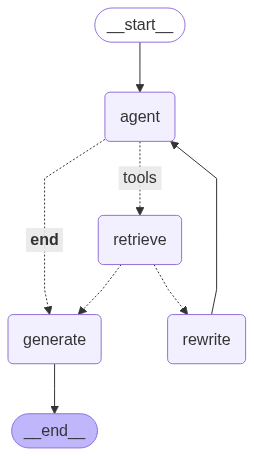

에이전트로 전달된 메시지들:  [HumanMessage(content='삼성전자 주가는?', additional_kwargs={}, response_metadata={}, id='26a9e7a2-3c43-4538-b341-8fd65e71b9c4')]
"노드 'agent'의 출력 결과:"
'---'
{ 'messages': [ HumanMessage(content='삼성전자 주가는?', additional_kwargs={}, response_metadata={}, id='26a9e7a2-3c43-4538-b341-8fd65e71b9c4'),
                AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_yH44eJOVCUhpMcp2oiGaxUeX', 'function': {'arguments': '{"query":"삼성전자 주가"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_62a23a81ef', 'service_tier': 'default'}, id='run--a2eaf547-8816-4b69-89e6-9260d0cb5a42-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': '삼성전자 주가'}, 'id': 'call_yH44eJOVCUhpMcp2oiGaxUeX', 'type': 'tool_call'}])]}
'\n---\n'
----문서 관련성 평가----
--결정: 문서 관련성 있음--
"노드 'retrieve'의 출력 결과:"
'---'
{ 'messages': [ ToolMessage(content='-0.43%\n\

In [ ]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
import pprint
inputs = {
    'messages': [('user', '삼성전자 주가는?') ]}

for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"노드 '{key}'의 출력 결과:")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")